In [15]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing

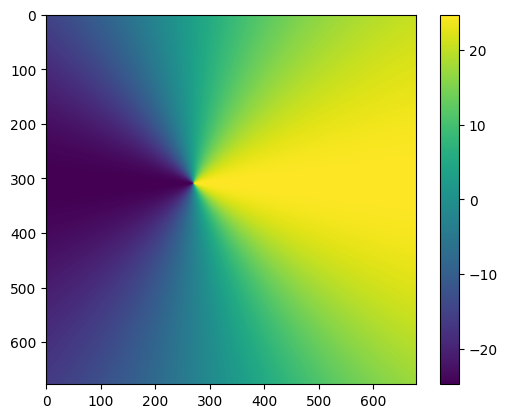

In [16]:
# use sie lens with similar values to verify the correctness of the model

#checking the vaildity of the source plane map

import matplotlib.pyplot as plt
# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
kwargs_sie = {'theta_E': 100, 'e1':0, 'e2':0.2, 'center_x': 270, 'center_y': 310}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.25
x_grid, y_grid = np.meshgrid(np.linspace(0, size, size), np.linspace(0, size, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2

alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

plt.imshow(alpha_x_arcsec)   #assume this is in arcsec
plt.colorbar()


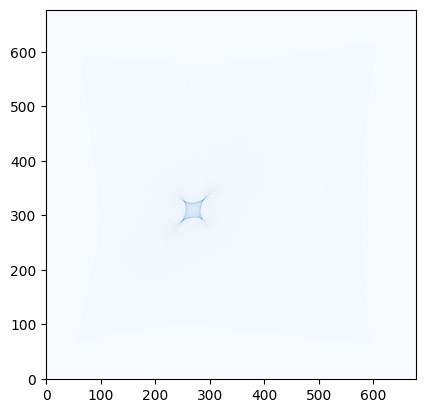

In [17]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()

[array([42.36912834, 89.26284703]), array([53.37749672, 56.43298306]), array([74.94663644, 52.62391384]), array([83.3869791 , 90.55767814])]
[array([42.56957377, 89.6787501 ]), array([53.27701787, 56.5007554 ]), array([75.58602542, 52.82633641]), array([83.43717771, 90.4961416 ])]
Image 1 position: [42.56957377 89.6787501 ]
Predicted Image 1 position: [42.36912834 89.26284703]
Difference: 0.4616857553475942
Image 2 position: [53.27701787 56.5007554 ]
Predicted Image 2 position: [53.37749672 56.43298306]
Difference: 0.12119856076991893
Image 3 position: [75.58602542 52.82633641]
Predicted Image 3 position: [74.94663644 52.62391384]
Difference: 0.6706662071075442
Image 4 position: [83.43717771 90.4961416 ]
Predicted Image 4 position: [83.3869791  90.55767814]
Difference: 0.0794143963174512


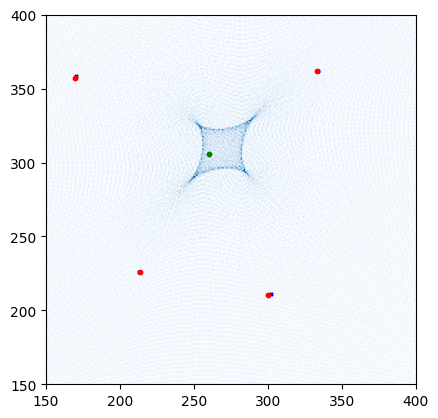

In [18]:
beta = (260.4,305.9) #in pixel

# lenstronomy
solver = LensEquationSolver(lensModel)
thetax, thetay = solver.image_position_analytical(beta[0], beta[1], kwargs_lens)

theta_analytical = [[] for _ in range(len(thetax))]

for i in range(len(thetax)):
    theta_analytical[i] = thetax[i], thetay[i]

theta_analytical = np.array(theta_analytical)
sorted_theta_analytical = sorted(theta_analytical * pixscale, key=lambda x: x[0])
print(sorted_theta_analytical)
# my class
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, 0.5 , 1.0, pixscale, 678, beta[0]*pixscale, beta[1]*pixscale)
theta_numerical = np.array(cluster.get_image_positions())
sorted_theta_numerical = sorted(theta_numerical, key=lambda x: x[0])
print(sorted_theta_numerical)
plt.scatter(theta_numerical[:,0] / pixscale, theta_numerical[:,1] / pixscale, color='blue', s=5, marker='x')
plt.scatter(thetax, thetay, color='red', s=10)
plt.scatter(beta[0], beta[1], color='green', s=10)
plt.imshow(array_test, cmap='Blues')
plt.gca().invert_yaxis()
plt.xlim(150,400)
plt.ylim(150,400)

for i in range(len(thetax)):
    print(f'Image {i+1} position: {sorted_theta_numerical[i]}')
    print(f'Predicted Image {i+1} position: {sorted_theta_analytical[i]}')
    print(f'Difference: {np.sqrt((sorted_theta_numerical[i][0]-sorted_theta_analytical[i][0])**2 + (sorted_theta_numerical[i][1]-sorted_theta_analytical[i][1])**2)}')   


In [11]:
theta = cluster.get_image_positions()
print(f"Numerical image position: {theta}")
mag = cluster.get_magnifications()
for i in range(len(theta)):
    print(f"magnification of {theta[i]} is {mag[i]}")
print("Analytical:")
for i in range(len(thetax)):
    mag = lensModel.magnification(thetax[i], thetay[i], kwargs_lens)
    print(f"magnification of {thetax[i]*pixscale, thetay[i]*pixscale} is {mag}")



Numerical image position: [(75.58602541021794, 52.82633640321001), (53.27701786864441, 56.50075540199475), (42.56957376514844, 89.67875010111486), (83.43717771293262, 90.49614160093753)]
magnification of (75.58602541021794, 52.82633640321001) is 6.0882822362618025
magnification of (53.27701786864441, 56.50075540199475) is -5.166096482505967
magnification of (42.56957376514844, 89.67875010111486) is 4.176282361099113
magnification of (83.43717771293262, 90.49614160093753) is -2.1045072446545467
Analytical:
magnification of (42.36912833618598, 89.26284702777586) is 4.177310353974561
magnification of (74.94663644064764, 52.62391383697358) is 6.268601256645032
magnification of (53.377496722764704, 56.4329830581831) is -5.562630469417336
magnification of (83.38697909762854, 90.55767813775931) is -2.082480883850224


In [12]:
# time delay
dt = cluster.get_time_delays()
z_l = 0.5
z_s = 1.0
for i in range(len(dt)):
    print(f"Time delay of {theta[i]} is {dt[i]} days")
# restore the lens model in arcsec
kwargs_sie = {'theta_E': 100 * pixscale, 'e1':0, 'e2':0.2, 'center_x': 270 * pixscale, 'center_y': 310 * pixscale}
kwargs_lens = [kwargs_sie]

lensModel = LensModel(lens_model_list=lens_model_list, z_source=z_s, z_lens=z_l)
print("Analytical:")
t_analytical = lensModel.arrival_time(thetax * pixscale, thetay * pixscale, kwargs_lens, x_source=beta[0] * pixscale, y_source=beta[1] * pixscale)
for i in range(len(thetax)):
    dt_analytical = t_analytical[i] - t_analytical[1]
    print(f"Time delay of {thetax[i]*pixscale, thetay[i]*pixscale} is {dt_analytical} days")


Time delay of (75.58602541021794, 52.82633640321001) is 0.0 days
Time delay of (53.27701786864441, 56.50075540199475) is 2146.343496434113 days
Time delay of (42.56957376514844, 89.67875010111486) is -6029.829974916451 days
Time delay of (83.43717771293262, 90.49614160093753) is 14917.767356000757 days
Analytical:
Time delay of (42.36912833618598, 89.26284702777586) is -6107.4303035057965 days
Time delay of (74.94663644064764, 52.62391383697358) is 0.0 days
Time delay of (53.377496722764704, 56.4329830581831) is 1979.8360974095121 days
Time delay of (83.38697909762854, 90.55767813775931) is 16050.091995521841 days
